# Write out annotations as cylinders

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from funlib.persistence import open_ds
from funlib.geometry import Roi

mask = open_ds(
    "/nrs/cellmap/ackermand/cellmap/jrc_mus-liver-zon-1.n5",
    "nucleus_surfaceVoxels_expansion80",
)  # in z,y,x
# mask.materialize()
frags = pd.read_csv(
    "/nrs/cellmap/ackermand/cellmap/analysisResults/jrc_mus-liver-zon-1/nuclear_pores.csv"
)
volume = frags["Volume (nm^3)"].to_numpy()
count = 0
ids = frags["Object ID"].to_numpy()
com_z = frags["COM Z (nm)"].to_numpy()
com_y = frags["COM Y (nm)"].to_numpy()
com_x = frags["COM X (nm)"].to_numpy()
ids_to_keep = np.zeros_like(ids)
blocks_in_mask = np.array(
    (com_z // (212 * 16), com_y // (212 * 16), com_x // (212 * 16)), dtype=int
).T
coms_in_mask_voxels = np.array((com_z // 16, com_y // 16, com_x // 16), dtype=int).T

unique_blocks, pore_unique_block_indices = np.unique(
    blocks_in_mask, axis=0, return_inverse=True
)
valid_volumes = volume >= (100 * 8**3)
roi_extent = 3 * [212 * 16]
for idx, current_block_index in tqdm(
    enumerate(unique_blocks), total=len(unique_blocks)
):
    roi_start_in_voxels = current_block_index * 212
    current_mask = mask.to_ndarray(
        Roi(roi_start_in_voxels * 16, roi_extent), fill_value=0
    )

    current_pore_indices = np.where((pore_unique_block_indices == idx) & valid_volumes)
    current_coms_in_mask_voxels = coms_in_mask_voxels[current_pore_indices]
    voxel_coordinate_in_current_mask = current_coms_in_mask_voxels - roi_start_in_voxels
    ids_to_keep[current_pore_indices] = current_mask[
        voxel_coordinate_in_current_mask[:, 0],
        voxel_coordinate_in_current_mask[:, 1],
        voxel_coordinate_in_current_mask[:, 2],
    ]

import pickle

with open("ids_to_keep.pkl", "wb") as handle:
    pickle.dump(ids_to_keep, handle, protocol=pickle.HIGHEST_PROTOCOL)

100%|██████████| 56107/56107 [41:26<00:00, 22.56it/s]


In [2]:
import dask.diagnostics
import dask.array as da
from dask.distributed import Client, LocalCluster
import numpy as np
from scipy.ndimage import binary_erosion
import socket
import itertools
from funlib.persistence import open_ds
from funlib.geometry import Roi
import itertools
import dask


def get_assignment_dict(current_block_index, mask, idx):
    roi_start_in_voxels = current_block_index * 212
    current_mask = mask.to_ndarray(
        Roi(roi_start_in_voxels * 16, roi_extent), fill_value=0
    )

    current_pore_indices = np.where((pore_unique_block_indices == idx) & valid_volumes)
    current_coms_in_mask_voxels = coms_in_mask_voxels[current_pore_indices]
    voxel_coordinate_in_current_mask = current_coms_in_mask_voxels - roi_start_in_voxels
    ids_to_keep[current_pore_indices] = current_mask[
        voxel_coordinate_in_current_mask[:, 0],
        voxel_coordinate_in_current_mask[:, 1],
        voxel_coordinate_in_current_mask[:, 2],
    ]
    didnt finish
    return ids_to_keep


with LocalCluster(n_workers=8, threads_per_worker=1) as cluster:
    with Client(cluster) as client:
        print(
            f'Click here to monitor job: {client.dashboard_link.replace("127.0.0.1", socket.gethostname())}'
        )
        # list comprehension to iterate over the blocks, lazily
        delayed_result = [
            dask.delayed(get_assignment_dict)(unique_block, mask, idx)
            for (idx, unique_block) in enumerate(unique_blocks)
        ]

        result = dask.delayed(list)(delayed_result)
        with dask.diagnostics.ProgressBar():
            print(result.compute())

Click here to monitor job: http://ackermand-ws2:8787/status


/groups/scicompsoft/home/ackermand/miniconda3/envs/cellmap_experiments/lib/python3.10/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 26.06 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(
2023-10-10 19:47:12,731 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distributed.dask.org/en/latest/worker-memory.html#memory-not-released-back-to-the-os for more information. -- Unmanaged memory: 8.38 GiB -- Worker memory limit: 11.76 GiB
2023-10-10 19:47:13,995 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 9.41 GiB -- Worker memory limit: 11.76 GiB
2023-10-10 19:47:14,483 - distributed.worker.memory - WARNING - Unmanaged memory use is high. This may indicate a memory leak or the memory may not be released to the OS; see https://distrib

KeyboardInterrupt: 

In [5]:
dask.diagnostics

<module 'dask.diagnostics' from '/groups/scicompsoft/home/ackermand/miniconda3/envs/cellmap_experiments/lib/python3.10/site-packages/dask/diagnostics/__init__.py'>

In [11]:
np.where(ids_to_keep)[0][0]

348

In [12]:
ids_to_keep[348]

52

In [13]:
ids[348], com_x[348] / 8, com_y[348] / 8, com_z[348] / 8

(3380189593602, 20986.26172707889, 4984.383262260128, 1466.0186567164178)

In [74]:
t = current_coms_in_mask_voxels - roi_start_in_voxels
current_mask[t[:, 0], t[:, 1], t[:, 2]]

array([1, 0, 0, 0, 0], dtype=uint16)

In [73]:
np.unique(current_mask)

array([ 0,  1, 22], dtype=uint16)

In [61]:
[tuple(t) for t in current_coms_in_mask_voxels - roi_start_in_voxels]

[(160, 196, 142),
 (19, 172, 179),
 (174, 203, 169),
 (17, 184, 121),
 (18, 169, 121)]

In [34]:
from funlib.geometry import Roi

mask.to_ndarray(Roi(np.array((0, 0, 2)) * 212 * 16, [212 * 16] * 3))

array([[[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  1,  1,  1],
        [ 0,  0,  0, ...,  1,  1,  1],
        [ 0,  0,  0, ...,  1,  1,  1]],

       [[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  1,  1,  1],
        [ 0,  0,  0, ...,  1,  1,  1],
        [ 0,  0,  0, ...,  1,  1,  1]],

       [[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [ 0,  0,  0, ...,  1,  1,  1],
        [ 0,  0,  0, ...,  1,  1,  1],
        [ 0,  0,  0, ...,  1,  1,  1]],

       ...,

       [[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [22, 22, 22, ...,  0,  0,  0],
        [22, 22, 22, ...,  0,  0,  0],
        [22, 22, 22, ...,  0,  0

In [47]:
mask.shape

(24822, 10724, 11800)

In [35]:
Roi(np.array((0, 0, 2)) * 212 * 16, [212 * 16] * 3)

[0:3392, 0:3392, 6784:10176] (3392, 3392, 3392)

In [27]:
temp = np.array(
    (com_z // (212 * 16), com_y // (212 * 16), com_x // (212 * 16)), dtype=np.int
).T

/tmp/ipykernel_23712/867904018.py:1: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  temp = np.array((com_z//(212*16), com_y//(212*16), com_x//(212*16)),dtype=np.int).T


In [39]:
unique_rows, idx = np.unique(temp, axis=0, return_inverse=True)

In [46]:
com_x[np.where(idx == 1)], com_y[np.where(idx == 1)], com_z[np.where(idx == 1)]

(array([11221.83370125, 11271.6875    , 10731.55195682, 13510.37728195,
        13528.        , 10348.4168392 ]),
 array([2987.69683591, 2996.125     , 3196.01079622, 2917.78661258,
        3176.        , 2759.68530021]),
 array([3029.96909492, 3022.59375   , 2698.49392713, 3090.39513185,
        3120.        ,  846.55900621]))

In [32]:
unique_rows

array([[  0,   0,   2],
       [  0,   0,   3],
       [  0,   0,   4],
       ...,
       [117,  49,  12],
       [117,  49,  13],
       [117,  49,  14]])

In [28]:
len(np.vstack({tuple(row) for row in temp}))

/tmp/ipykernel_23712/534726858.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  len(np.vstack({tuple(row) for row in temp}))


56107

In [2]:
from scipy import spatial

tree = spatial.KDTree(
    np.column_stack([com_x[ids_to_keep], com_y[ids_to_keep], com_z[ids_to_keep]])
)

In [6]:
mask = open_ds(
    "/nrs/cellmap/ackermand/cellmap/jrc_mus-liver-zon-1.n5",
    "nucleus_surfaceVoxels_expansion80",
)
mask.voxel_size

(16, 16, 16)

In [5]:
np.sum(valid_volumes)

3489657

In [36]:
import struct
import os
import struct
import numpy as np
import json
from time import sleep
from datetime import datetime
import pandas as pd
from tqdm import tqdm
from scipy import spatial


def write_precomputed_annotations(
    annotation_type, annotations, densities, relationships_dict
):
    # write_time = datetime.now().strftime("%Y%m%d_%H%M%S")
    output_directory = f"/groups/cellmap/cellmap/ackermand/neuroglancer_annotations/segmentations/nuclear_pores_with_property_{annotation_type}"
    os.system(f"rm -rf {output_directory}")
    os.makedirs(f"{output_directory}/spatial0", exist_ok=True)
    os.makedirs(f"{output_directory}/relationships", exist_ok=True)

    if annotation_type == "line":
        coords_to_write = 6
    else:
        coords_to_write = 3

    annotations_and_densities = list(zip(annotations, densities))
    with open(f"{output_directory}/spatial0/0_0_0", "wb") as outfile:
        total_count = len(annotations)
        buf = struct.pack("<Q", total_count)
        flattened = np.column_stack((annotations, densities)).flatten()
        # for annotation, density in tqdm(annotations_and_densities):

        #     annotation_buf = struct.pack(f"<{coords_to_write}f", *annotation)
        #     buf += annotation_buf
        #     buf += struct.pack(f"<1f", np.float32(density))  # property
        buf += struct.pack(f"<{(coords_to_write+1)*total_count}f", *flattened)
        # if c < 10000:
        #     buf += struct.pack(f"<I", 1)  # number of objects it is associated with
        #     buf += struct.pack(f"<Q", 1)  # ids it is associated with
        # else:
        #     buf += struct.pack(f"<I", 0)  # ids it is associated with

        # write the ids at the end of the buffer as increasing integers
        id_buf = struct.pack(
            f"<{total_count}Q", *range(1, len(annotations) + 1, 1)
        )  # so start at 1
        # id_buf = struct.pack('<%sQ' % len(coordinates), 3,1 )#s*range(len(coordinates)))
        buf += id_buf
        outfile.write(buf)
    for nucleus_id, nuclear_pore_indices in relationships_dict.items():
        with open(f"{output_directory}/relationships/{nucleus_id}", "wb") as outfile:
            total_count = len(nuclear_pore_indices)
            buf = struct.pack("<Q", total_count)
            flattened = np.column_stack(
                (annotations[nuclear_pore_indices], densities[nuclear_pore_indices])
            ).flatten()
            print(total_count, flattened)

            # for annotation, density in tqdm(annotations_and_densities):

            #     annotation_buf = struct.pack(f"<{coords_to_write}f", *annotation)
            #     buf += annotation_buf
            #     buf += struct.pack(f"<1f", np.float32(density))  # property
            buf += struct.pack(f"<{(coords_to_write+1)*total_count}f", *flattened)
            # annotations_and_densities = list(zip(annotations, densities))
            # total_count = len(annotations_and_densities)
            # buf = struct.pack("<Q", total_count)
            # for annotation, density in tqdm(annotations_and_densities):
            #     annotation_buf = struct.pack(f"<{coords_to_write}f", *annotation)
            #     buf += annotation_buf
            #     buf += struct.pack(f"<1f", np.float32(density))  # property

            # write the ids at the end of the buffer as increasing integers
            id_buf = struct.pack(
                f"<{total_count}Q", *range(1, total_count + 1, 1)
            )  # so start at 1
            # id_buf = struct.pack('<%sQ' % len(coordinates), 3,1 )#s*range(len(coordinates)))
            buf += id_buf
            outfile.write(buf)

    max_extents = annotations.reshape((-1, 3)).max(axis=0) + 1
    max_extents = [int(max_extent) for max_extent in max_extents]
    info = {
        "@type": "neuroglancer_annotations_v1",
        "dimensions": {"x": [1, "nm"], "y": [1, "nm"], "z": [1, "nm"]},
        "by_id": {"key": "by_id"},
        "lower_bound": [0, 0, 0],
        "upper_bound": max_extents,
        "annotation_type": annotation_type,
        "properties": [{"id": "density", "type": "float32", "description": "density"}],
        "relationships": [{"id": "associated_column_cell", "key": "relationships"}],
        "spatial": [
            {
                "chunk_size": max_extents,
                "grid_shape": [1, 1, 1],
                "key": "spatial0",
                "limit": 1,
            }
        ],
    }

    with open(f"{output_directory}/info", "w") as info_file:
        json.dump(info, info_file)

    return output_directory.replace(
        "/groups/cellmap/cellmap/ackermand/",
        "precomputed://https://cellmap-vm1.int.janelia.org/dm11/ackermand/",
    )


frags = pd.read_csv(
    "/nrs/cellmap/ackermand/cellmap/analysisResults/jrc_mus-liver-zon-1/nuclear_pores.csv"
)
id = frags["Object ID"]
com_x = frags["COM X (nm)"].to_numpy()
com_y = frags["COM Y (nm)"].to_numpy()
com_z = frags["COM Z (nm)"].to_numpy()
min_x = frags["MIN X (nm)"].to_numpy()
min_y = frags["MIN Y (nm)"].to_numpy()
min_z = frags["MIN Z (nm)"].to_numpy()
max_x = frags["MAX X (nm)"].to_numpy()
max_y = frags["MAX Y (nm)"].to_numpy()
max_z = frags["MAX Z (nm)"].to_numpy()
annotations = np.column_stack(
    (
        min_x[ids_to_keep],
        min_y[ids_to_keep],
        min_z[ids_to_keep],
        max_x[ids_to_keep],
        max_y[ids_to_keep],
        max_z[ids_to_keep],
    )
)

# import numpy as np
# import scipy.spatial as spatial

ids_to_keep_binarized = ids_to_keep > 0
tree = spatial.KDTree(
    np.column_stack(
        [
            com_x[ids_to_keep_binarized],
            com_y[ids_to_keep_binarized],
            com_z[ids_to_keep_binarized],
        ]
    )
)
radius = 1000.0
neighbors = tree.query_ball_tree(tree, radius)
densities = np.array([len(n) for n in neighbors])
densities = densities / densities.max()

write_precomputed_annotations("line", annotations)
write_precomputed_annotations(
    "line",
    annotations,
    densities,
)
ids_to_keep_finalized = ids_to_keep[ids_to_keep_binarized]
nucleus_ids = np.unique(ids_to_keep_finalized)
relationships_dict = {
    nucleus_id: np.where(ids_to_keep_finalized == nucleus_id)[0]
    for nucleus_id in nucleus_ids
}
write_precomputed_annotations(
    "point",
    np.column_stack(
        (
            com_x[ids_to_keep_binarized],
            com_y[ids_to_keep_binarized],
            com_z[ids_to_keep_binarized],
        )
    ),
    densities,
    relationships_dict,
)

69 [8.64377903e+03 3.71984386e+03 7.08038372e+02 1.98019802e-02
 1.12218337e+04 2.98769684e+03 3.02996909e+03 4.95049505e-02
 9.92385667e+03 4.37966722e+03 1.48186326e+03 8.91089109e-02
 9.77524216e+03 4.27764662e+03 1.58748270e+03 9.90099010e-02
 1.12716875e+04 2.99612500e+03 3.02259375e+03 4.95049505e-02
 1.03384879e+04 4.57353322e+03 1.08004468e+03 1.18811881e-01
 1.10762286e+04 4.82265714e+03 1.30002857e+03 1.28712871e-01
 1.10714352e+04 4.89531019e+03 1.30725926e+03 1.28712871e-01
 1.05061514e+04 4.50591914e+03 1.74110554e+03 1.28712871e-01
 1.03312947e+04 4.41874887e+03 1.80643814e+03 1.08910891e-01
 1.06275516e+04 4.49336099e+03 1.83810568e+03 1.28712871e-01
 1.14034948e+04 4.90630007e+03 1.24253826e+03 1.18811881e-01
 1.15243838e+04 4.82617069e+03 1.87165941e+03 8.91089109e-02
 1.49944329e+04 2.94234290e+03 1.44336385e+03 1.98019802e-02
 1.49355168e+04 2.97738830e+03 1.62819559e+03 1.98019802e-02
 1.26606706e+04 5.23938963e+03 8.00989967e+02 3.96039604e-02
 1.16461275e+04 4.763

'precomputed://https://cellmap-vm1.int.janelia.org/dm11/ackermand/neuroglancer_annotations/segmentations/nuclear_pores_with_property_point'

good link: https://neuroglancer-demo.appspot.com/#!gs://flyem-user-links/short/2023-10-11.011152.json

# pore-pore density

Text(0, 0.5, 'Density (pores per micron sphere)')

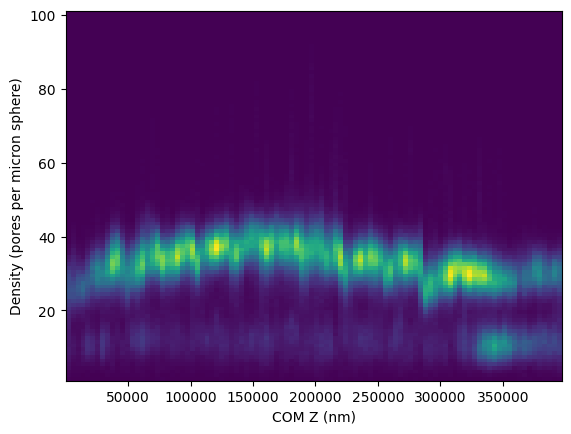

In [10]:
import matplotlib.pyplot as plt
import matplotlib
import pickle
import pandas as pd
import numpy as np
from scipy import spatial

with open("ids_to_keep.pkl", "rb") as f:
    ids_to_keep = pickle.load(f)

frags = pd.read_csv(
    "/nrs/cellmap/ackermand/cellmap/analysisResults/jrc_mus-liver-zon-1/nuclear_pores.csv"
)
id = frags["Object ID"]
com_x = frags["COM X (nm)"].to_numpy()
com_y = frags["COM Y (nm)"].to_numpy()
com_z = frags["COM Z (nm)"].to_numpy()
min_x = frags["MIN X (nm)"].to_numpy()
min_y = frags["MIN Y (nm)"].to_numpy()
min_z = frags["MIN Z (nm)"].to_numpy()
max_x = frags["MAX X (nm)"].to_numpy()
max_y = frags["MAX Y (nm)"].to_numpy()
max_z = frags["MAX Z (nm)"].to_numpy()
annotations = np.column_stack(
    (
        min_x[ids_to_keep],
        min_y[ids_to_keep],
        min_z[ids_to_keep],
        max_x[ids_to_keep],
        max_y[ids_to_keep],
        max_z[ids_to_keep],
    )
)

# import numpy as np
# import scipy.spatial as spatial

ids_to_keep_binarized = ids_to_keep > 0
tree = spatial.KDTree(
    np.column_stack(
        [
            com_x[ids_to_keep_binarized],
            com_y[ids_to_keep_binarized],
            com_z[ids_to_keep_binarized],
        ]
    )
)
radius = 1000.0
neighbors = tree.query_ball_tree(tree, radius)
densities = np.array([len(n) for n in neighbors])
#densities = densities / densities.max()

import matplotlib

plt.hist2d(com_z[ids_to_keep>0], densities,bins=100)
plt.xlabel("COM Z (nm)")
plt.ylabel("Density (pores per micron sphere)")

# density per nucleus

Text(0, 0.5, 'Density (pores per nucleus)')

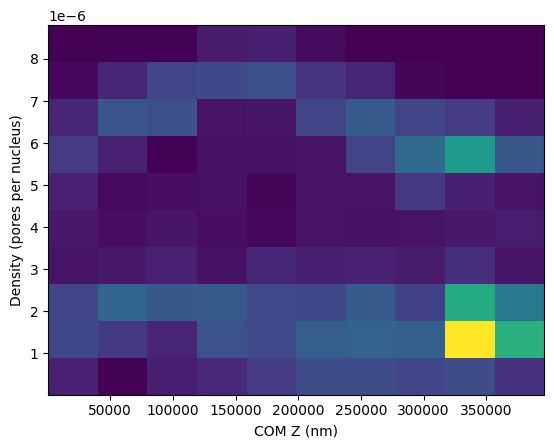

In [12]:
import matplotlib.pyplot as plt
import matplotlib
import pickle
import pandas as pd
import numpy as np
from scipy import spatial

with open("ids_to_keep.pkl", "rb") as f:
    ids_to_keep = pickle.load(f)
nucleus_info = pd.read_csv(
    "/nrs/cellmap/ackermand/cellmap/analysisResults/jrc_mus-liver-zon-1/nucleus.csv"
)
nucleus_ids, counts = np.unique(ids_to_keep[ids_to_keep>0], return_counts=True)
nucleus_com_z = np.zeros_like(nucleus_ids, dtype = float)
nucleus_density = np.zeros_like(nucleus_ids, dtype = float)
for i,(nucleus_id,counts) in enumerate(zip(nucleus_ids,counts)):
    current_nucleus_info = nucleus_info[nucleus_info["Object ID"]==nucleus_id]
    nucleus_com_z[i] = current_nucleus_info["COM Z (nm)"]
    nucleus_density[i] = counts/current_nucleus_info["Surface Area (nm^2)"]

plt.hist2d(nucleus_com_z, nucleus_density)
plt.xlabel("COM Z (nm)")
plt.ylabel("Density (pores per nucleus)")

In [13]:
len(nucleus_info)

2203

Text(0, 0.5, 'Density (pores per micron sphere)')

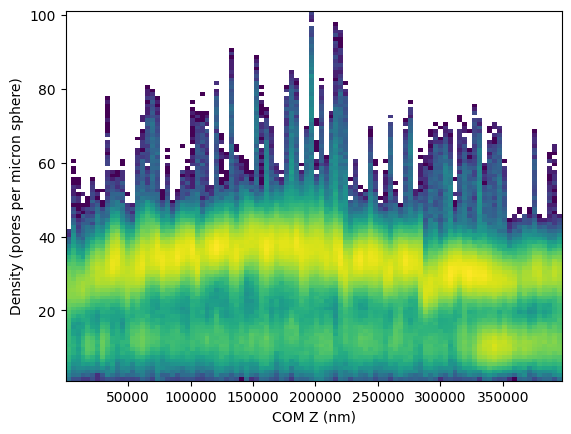

In [9]:
import matplotlib

plt.hist2d(com_z[ids_to_keep>0], densities,bins=100,norm=matplotlib.colors.LogNorm())
plt.xlabel("COM Z (nm)")
plt.ylabel("Density (pores per micron sphere)")